In [2]:
## необходимые пакеты и настройки перед установкой finrl в колабе
!pip install swig
!pip install wrds
!pip install pyportfolioopt
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# установка finrl
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✨🍰✨ Everything looks OK!
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-dbfs0kzy
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-dbfs0kzy
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit b3e3367ba2d0901eed08d196aef86102a65725e1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-p_l2cvk_/pyfolio_998ddc9307c44222

In [3]:
# import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
# from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
# from finrl.meta.data_processor import DataProcessor
# from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys
sys.path.append("../FinRL-Library")

/usr/local/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [4]:
# Create Folders
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [5]:
# тут пришлось заменить яху-препроцессор на свой код, т.к. тот не хотел загружать
import yfinance as yf
import pandas as pd

#tickers = ['AAPL', 'XOM']
# start_date = pd.Timestamp.now() - pd.DateOffset(months=1)
# end_date = pd.Timestamp.now()

# история биткоина на яху доступна только с осени 2014
tickers = ['EURUSD=X', 'GC=F', 'BTC-USD', 'AAPL', 'XOM', 'V', 'CL=F']
start_date = '2015-01-01'
end_date = '2022-12-31'
start_train = '2016-01-01'
end_train = '2019-12-31'
start_test = '2020-01-01'
end_test = end_date

df_src = pd.DataFrame()

for ticker in tickers:
    df_one = yf.download(ticker, start=start_date, end=end_date, interval='1wk')
    df_one['tic'] = ticker
    df_src = pd.concat([df_src, df_one])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
df_prep = df_src.reset_index()
# df_prep.rename(columns={'index': 'date'}, inplace=True)
df_prep.columns = df_prep.columns.str.lower()
df_prep = df_prep.sort_values(by=['date']).reset_index(drop=True)
df_prep = df_prep.drop('adj close', axis=1)
# заполним пропуски последними известными значениями
# df_prep = df_prep.fillna(method='ffill')
print(df_prep.shape)
df_prep.head()

(2926, 7)


,date,open,high,low,close,volume,tic
0,2015-01-01,1.209863,1.209863,1.180401,1.187536,0,EURUSD=X
1,2015-01-01,27.847500,27.860001,26.157499,26.937500,893572400,AAPL
2,2015-01-01,92.250000,93.050003,89.019997,90.720001,58984200,XOM
3,2015-01-01,320.434998,320.434998,257.612000,294.337006,196656000,BTC-USD
4,2015-01-01,1184.000000,1220.000000,1169.500000,1210.599976,734,GC=F


# Preprocess Data

In [7]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df_prep)
print(df.shape)
print(df['tic'].unique())

Successfully added technical indicators
(2926, 15)
['AAPL' 'BTC-USD' 'CL=F' 'EURUSD=X' 'GC=F' 'V' 'XOM']


In [8]:
# Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date','tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 52 # для недель
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback = data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)
  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)
print(df.shape)
df.head()

(2562, 17)


,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2015-12-31,26.752501,26.757500,24.967501,25.174999,931240400,AAPL,-0.793089,30.690875,25.822375,38.776883,-169.443325,46.183985,29.048250,29.899953,"[[0.0008660335255067772, 9.527441363476244e-05...",tic AAPL BTC-USD CL=F EURU...
1,2015-12-31,425.875000,436.246002,418.734985,429.105011,259048500,BTC-USD,46.909734,488.350757,148.631043,62.519033,139.896025,67.972435,300.553533,273.771830,"[[0.0008660335255067772, 9.527441363476244e-05...",tic AAPL BTC-USD CL=F EURU...
2,2015-12-31,36.810001,38.389999,33.770000,33.970001,1689550,CL=F,-3.533193,50.981468,33.522532,37.954517,-142.435620,43.382196,45.082667,48.423773,"[[0.0008660335255067772, 9.527441363476244e-05...",tic AAPL BTC-USD CL=F EURU...
3,2015-12-31,1.093805,1.094600,1.071201,1.075199,0,EURUSD=X,-0.007903,1.159311,1.048884,43.038163,-92.160904,4.780199,1.104515,1.108772,"[[0.0008660335255067772, 9.527441363476244e-05...",tic AAPL BTC-USD CL=F EURU...
4,2015-12-31,1061.900024,1093.699951,1058.500000,1091.900024,287,GC=F,-21.040788,1186.331987,1029.777986,43.721246,-75.899439,17.343116,1117.023319,1156.650936,"[[0.0008660335255067772, 9.527441363476244e-05...",tic AAPL BTC-USD CL=F EURU...


# Design Environment

In [9]:
train = data_split(df, start_train, end_train)
train.head()

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2016-01-07,24.670000,25.297501,24.107500,24.347500,1252902400,AAPL,-1.009736,31.085604,25.120146,36.951882,-205.297428,50.166932,28.799000,29.797129,"[[0.0008773252560457615, 0.0002662070256250613...",tic AAPL BTC-USD CL=F EURU...
0,2016-01-07,430.010986,462.933990,424.442993,432.371002,542774100,BTC-USD,47.581458,500.066346,157.569455,62.751913,135.680129,70.548487,306.656433,276.708852,"[[0.0008773252560457615, 0.0002662070256250613...",tic AAPL BTC-USD CL=F EURU...
0,2016-01-07,34.090000,34.340000,29.930000,30.480000,3127666,CL=F,-3.972224,51.939388,31.752612,35.553350,-182.718249,51.091061,44.101333,48.091481,"[[0.0008773252560457615, 0.0002662070256250613...",tic AAPL BTC-USD CL=F EURU...
0,2016-01-07,1.077795,1.096996,1.077400,1.084399,0,EURUSD=X,-0.007734,1.150863,1.050263,44.716884,-65.845422,3.302662,1.103188,1.108320,"[[0.0008773252560457615, 0.0002662070256250613...",tic AAPL BTC-USD CL=F EURU...
0,2016-01-07,1091.599976,1111.099976,1081.500000,1087.500000,400,GC=F,-19.556319,1184.584428,1027.815547,43.272830,-47.784857,7.650450,1114.059985,1155.370364,"[[0.0008773252560457615, 0.0002662070256250613...",tic AAPL BTC-USD CL=F EURU...


In [10]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=52,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (52**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
            #print(self.state)
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value 
            #print("Step reward: ", self.reward)
            #self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output
    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [11]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 7, State Space: 7


In [12]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# Implement DRL Algorithms

In [13]:
agent = DRLAgent(env = env_train)

### Model 1: A2C

In [29]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000)

trained_a2c.save('/content/trained_models/trained_a2c.zip')

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cuda device
begin_total_asset:1000000
end_total_asset:2773560.897404658
Sharpe:  1.7034072452463953
begin_total_asset:1000000
end_total_asset:3339447.3717809315
Sharpe:  1.8028391138167694
-------------------------------------
| time/                 |           |
|    fps                | 256       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -9.9      |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 4.89e+07  |
|    reward             | 1776327.9 |
|    std                | 0.995     |
|    value_loss         | 2.79e+13  |
-------------------------------------
begin_total_asset:1000000
end_total_asset:2805195.4293306433
Sharpe:  1.6637102571171278
begin_total_asset:1000000
end_total_asset:2853619

### Model 2: PPO

In [30]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=80000)

trained_ppo.save('/content/trained_models/trained_ppo.zip')

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device
begin_total_asset:1000000
end_total_asset:2694789.161678013
Sharpe:  1.6251912239632105
begin_total_asset:1000000
end_total_asset:3056333.084877177
Sharpe:  1.8730540182123658
begin_total_asset:1000000
end_total_asset:3042242.873873824
Sharpe:  1.829986009893874
begin_total_asset:1000000
end_total_asset:2922525.681664151
Sharpe:  1.71796463252171
begin_total_asset:1000000
end_total_asset:2179060.7938171695
Sharpe:  1.3233538428030545
begin_total_asset:1000000
end_total_asset:2524297.851515586
Sharpe:  1.4493201366310355
begin_total_asset:1000000
end_total_asset:3005102.632348915
Sharpe:  1.9548866605931412
begin_total_asset:1000000
end_total_asset:2799202.1598941805
Sharpe:  1.648887712137937
begin_total_asset:1000000
end_total_asset:2738624.4707761747
Sharpe:  1.6268881913831355
----------------------------------
| time/              |           |
|    fps             | 241       |
|    

### Model 3: DDPG

In [31]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [32]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

trained_ddpg.save('/content/trained_models/trained_ddpg.zip')

begin_total_asset:1000000
end_total_asset:2932325.711442079
Sharpe:  1.4359330163097639
begin_total_asset:1000000
end_total_asset:4536531.417528796
Sharpe:  1.5788412563590988
begin_total_asset:1000000
end_total_asset:4536531.417528796
Sharpe:  1.5788412563590988
begin_total_asset:1000000
end_total_asset:4536531.417528796
Sharpe:  1.5788412563590988
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 134       |
|    time_elapsed    | 6         |
|    total_timesteps | 832       |
| train/             |           |
|    actor_loss      | -5.65e+06 |
|    critic_loss     | 4.59e+11  |
|    learning_rate   | 0.001     |
|    n_updates       | 624       |
|    reward          | 4536531.5 |
----------------------------------
begin_total_asset:1000000
end_total_asset:4536531.417528796
Sharpe:  1.5788412563590988
begin_total_asset:1000000
end_total_asset:4536531.417528796
Sharpe:  1.5788412563590988
begin_total_asset

# Trading

In [33]:
# Assume that we have $1,000,000 initial capital at 2019-01-01.
# use the A2C vs PPO vs DDPG model to trade Dow jones 30 stocks.
trade = data_split(df, start_test, end_test)
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)
trade.shape

(1099, 17)

In [34]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=model_ppo,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1655543.6459291698
Sharpe:  0.7628958979131533
hit end!


In [35]:
df_daily_return['daily_return'].sum()

0.6134204504526714

In [36]:
df_actions.head()

,AAPL,BTC-USD,CL=F,EURUSD=X,GC=F,V,XOM
date,,,,,,,
2020-01-02,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
2020-01-09,0.144961,0.142434,0.142434,0.142434,0.142434,0.142434,0.142868
2020-01-16,0.144961,0.142434,0.142434,0.142434,0.142434,0.142434,0.142868
2020-01-23,0.144846,0.142441,0.142441,0.142441,0.142441,0.142441,0.142949
2020-01-30,0.144846,0.142441,0.142441,0.142441,0.142441,0.142441,0.142949


# Backtest Our Strategy

In [37]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

/usr/local/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [38]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          1.246056
Cumulative returns     0.655544
Annual volatility      0.586267
Sharpe ratio           1.679438
Calmar ratio           3.855108
Stability              0.714697
Max drawdown          -0.323222
Omega ratio            1.349607
Sortino ratio          2.408136
Skew                  -0.751197
Kurtosis               4.612865
Tail ratio             1.227743
Daily value at risk   -0.069956
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [39]:
#Benchmark stats
print("==============Get Benchmark Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Benchmark Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (754, 8)
Annual return          0.044396
Cumulative returns     0.138797
Annual volatility      0.251929
Sharpe ratio           0.299366
Calmar ratio           0.119712
Stability              0.456431
Max drawdown          -0.370862
Omega ratio            1.062327
Sortino ratio          0.413719
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.946772
Daily value at risk   -0.031441
dtype: float64


/usr/local/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


# BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (756, 8)


/usr/local/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.9/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2020-01-02
End date,2022-12-29
Total months,7
,Backtest
Annual return,124.606%
Cumulative returns,65.554%
Annual volatility,58.627%
Sharpe ratio,1.68
Calmar ratio,3.86
Stability,0.71
Max drawdown,-32.322%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.32,2020-02-06,2020-03-12,2020-06-04,86
1,20.91,2022-03-24,2022-09-22,NaT,NaN
2,8.60,2020-08-27,2020-09-17,2020-11-05,51
3,7.42,2021-10-14,2021-11-25,2022-02-03,81
4,6.08,2021-04-29,2021-05-13,2021-08-19,81


/usr/local/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warni

Stress Events,mean,min,max
New Normal,0.39%,-18.61%,11.49%


/usr/local/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


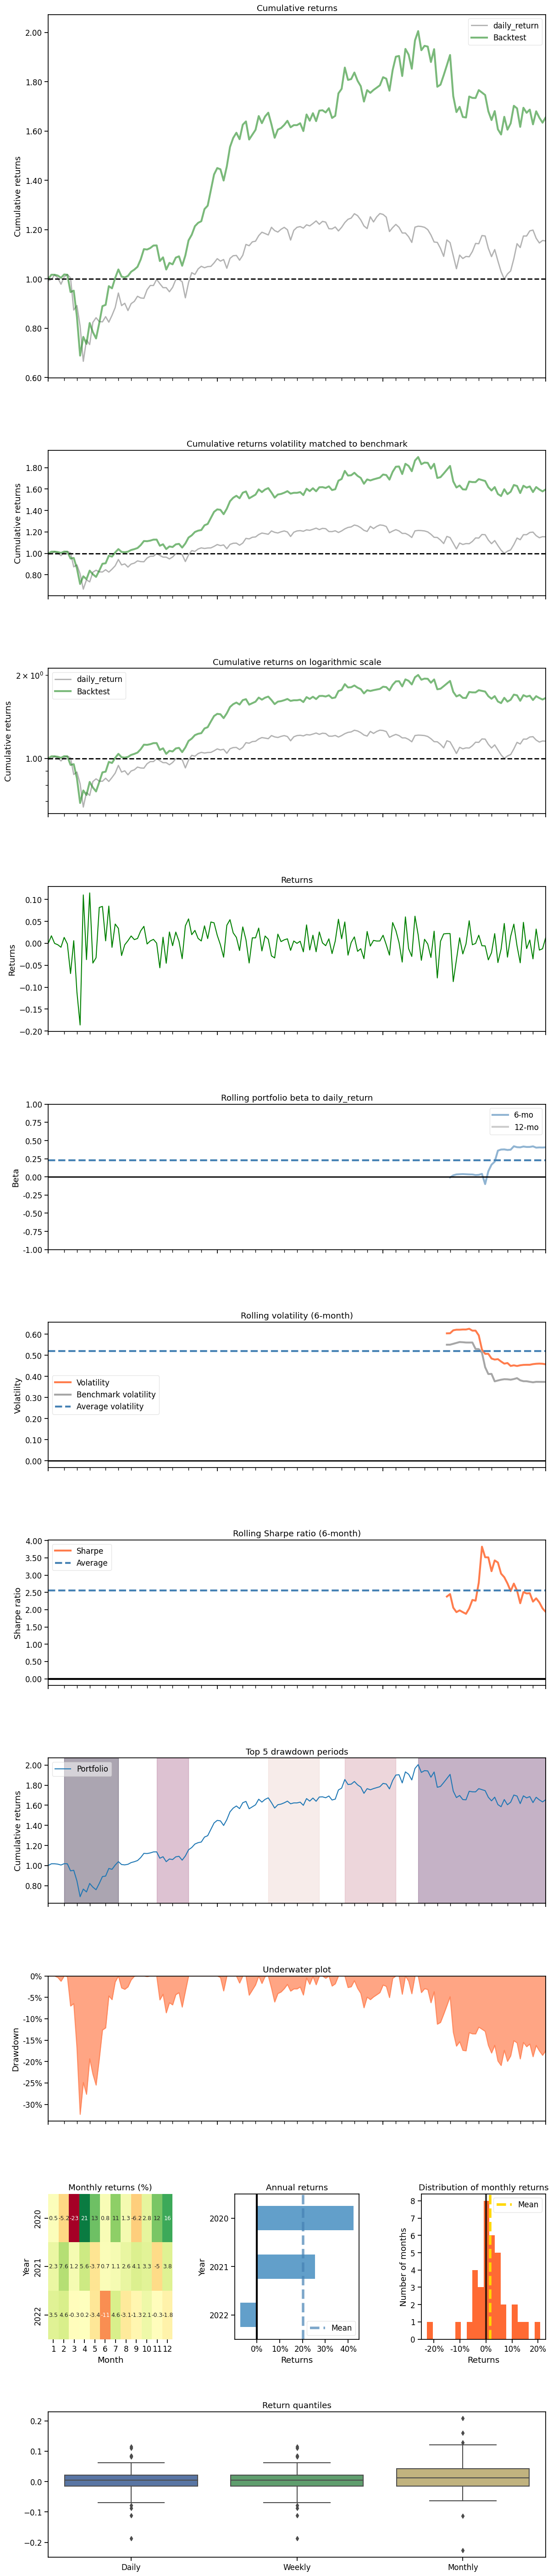

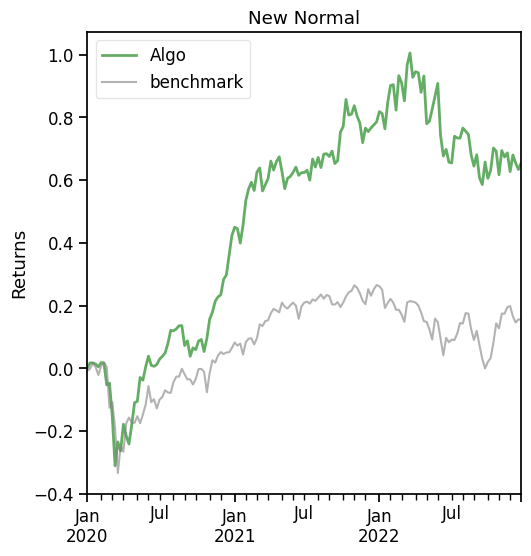

In [40]:
import pyfolio
%matplotlib inline


baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end=end_test
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

# костыль для перехода бенчмарка на недели
baseline_returns_w = baseline_returns.resample('W').sum()
baseline_returns_w.index = baseline_returns_w.index - pd.DateOffset(days=3)

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns_w, set_context=False)

# Min-Variance Portfolio Allocation

In [41]:
%pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()
df.head()

,date,open,high,low,close,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2015-12-31,26.752501,26.757500,24.967501,25.174999,931240400,AAPL,-0.793089,30.690875,25.822375,38.776883,-169.443325,46.183985,29.048250,29.899953,"[[0.0008660335255067772, 9.527441363476244e-05...",tic AAPL BTC-USD CL=F EURU...
1,2015-12-31,425.875000,436.246002,418.734985,429.105011,259048500,BTC-USD,46.909734,488.350757,148.631043,62.519033,139.896025,67.972435,300.553533,273.771830,"[[0.0008660335255067772, 9.527441363476244e-05...",tic AAPL BTC-USD CL=F EURU...
2,2015-12-31,36.810001,38.389999,33.770000,33.970001,1689550,CL=F,-3.533193,50.981468,33.522532,37.954517,-142.435620,43.382196,45.082667,48.423773,"[[0.0008660335255067772, 9.527441363476244e-05...",tic AAPL BTC-USD CL=F EURU...
3,2015-12-31,1.093805,1.094600,1.071201,1.075199,0,EURUSD=X,-0.007903,1.159311,1.048884,43.038163,-92.160904,4.780199,1.104515,1.108772,"[[0.0008660335255067772, 9.527441363476244e-05...",tic AAPL BTC-USD CL=F EURU...
4,2015-12-31,1061.900024,1093.699951,1058.500000,1091.900024,287,GC=F,-21.040788,1186.331987,1029.777986,43.721246,-75.899439,17.343116,1117.023319,1156.650936,"[[0.0008660335255067772, 9.527441363476244e-05...",tic AAPL BTC-USD CL=F EURU...


In [43]:
#calculate_portfolio_minimum_variance
portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = df[df.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = df[df.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma, weight_bounds=(0, 0.1))
    #minimum variance
    # если ошибка тут, то см https://github.com/robertmartin8/PyPortfolioOpt/issues/88
    # скорее всего, из-за волатильности крипты
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
portfolio=portfolio.T
portfolio.columns = ['account_value']

OptimizationError: ignored

In [ ]:
portfolio.tail()

In [ ]:
a2c_cumpod =(df_daily_return.daily_return+1).cumprod()-1
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1
dji_cumpod =(baseline_returns+1).cumprod()-1

# Plotly: DRL, Min-Variance, DJIA

In [ ]:
%pip install plotly

In [ ]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [ ]:
time_ind = pd.Series(df_daily_return.date)

In [ ]:
trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C (Portfolio Allocation)')

trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
#trace3_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
#trace4_portfolio = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')
#trace5_portfolio = go.Scatter(x = time_ind, y = min_cumpod, mode = 'lines', name = 'Min-Variance')

#trace4 = go.Scatter(x = time_ind, y = addpg_cumpod, mode = 'lines', name = 'Adaptive-DDPG')

#trace2 = go.Scatter(x = time_ind, y = portfolio_cost_minv, mode = 'lines', name = 'Min-Variance')
#trace3 = go.Scatter(x = time_ind, y = spx_value, mode = 'lines', name = 'SPX')

In [ ]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)

fig.add_trace(trace1_portfolio)

fig.add_trace(trace2_portfolio)

fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    paper_bgcolor='rgba(1,1,0,0)',
    plot_bgcolor='rgba(1, 1, 0, 0)',
    #xaxis_title="Date",
    yaxis_title="Cumulative Return",
xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()